In [1]:
import yaml
import glob
import numpy as np
import pickle
import pandas as pd
import sqlite3


In [3]:
config = yaml.safe_load(open('../config.yaml'))

In [4]:
LABEL                  = config["general"]["label"]

FEATURES_TO_DISCRETIZE = config['etl']['features_to_discretize']
DISCRETE_FEATURES      = config['etl']['discrete_features']
REG_FEATURES           = config['etl']['reg_features']
day_risk_groups        = config['etl']['day_risk_groups']


In [5]:
df = pd.read_csv('../dataset/raw_dataset.csv')


In [20]:
indexNames = df[ df['total_earning'] == 0 ].index
df.drop(indexNames , inplace=True)

indexNames = df[ df['to_user_distance'] == 0 ].index
df.drop(indexNames , inplace=True)


In [6]:
df['day_of_week'] = pd.to_datetime(df['created_at']).apply(lambda x: '{dayofweek}'.format(dayofweek=x.dayofweek)).astype(str)
df['rate_earning_distance'] = df.total_earning/df.to_user_distance
df['rate_earning_elevation'] = df.total_earning/df.to_user_elevation
df['negative_el_diff'] = (df.to_user_elevation<0).astype(int)


In [7]:
for risk_group in day_risk_groups:
    df[risk_group] = (df.day_of_week.isin(day_risk_groups[risk_group])).astype(int)


In [8]:
conn = sqlite3.connect('raw_dataset.db')
df.to_sql('couriers_rejection',conn, if_exists='replace')


In [9]:
with open('sql_queries/store_not_taken_rates.sql', 'r') as query_file:
    store_rates_query = query_file.read()
    df_store_rates = pd.read_sql_query(store_rates_query, conn).fillna(0)


In [10]:
df = pd.merge(left=df,right=df_store_rates, left_on='order_id', right_on='order_id')


In [11]:

#discrete features
discretized_dataset = df[DISCRETE_FEATURES + REG_FEATURES]

quantiles = [0, .25, .75, .9, .95, 1.]

#get quantiles for each column
for feature in FEATURES_TO_DISCRETIZE:
    discretized_dataset['discrete_'+feature] = pd.qcut(df[feature], q=quantiles, labels=range(1,len(quantiles)))

#one-hot encoding
discretized_dataset = pd.get_dummies(discretized_dataset)

#add labels
discretized_dataset[LABEL] = pd.to_numeric(df[LABEL])

#print result
discretized_dataset.head(10)

/Users/mcoria/anaconda3/envs/customenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,day_risk_group_1,day_risk_group_2,day_risk_group_3,day_risk_group_4,store_not_taken_rate_2d,store_not_taken_rate_1d,store_not_taken_rate_12h,store_not_taken_rate_3h,store_not_taken_rate_1h,to_user_distance,...,discrete_to_user_elevation_2,discrete_to_user_elevation_3,discrete_to_user_elevation_4,discrete_to_user_elevation_5,discrete_total_earning_1,discrete_total_earning_2,discrete_total_earning_3,discrete_total_earning_4,discrete_total_earning_5,taken
0,0,1,0,0,0.0667,0.1667,0.2500,1.0000,0.0000,2.478101,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0.2400,0.2727,0.3750,0.5000,0.6667,0.451711,...,1,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0.0645,0.1176,0.1282,0.2105,0.3636,2.026072,...,0,0,0,1,1,0,0,0,0,0
3,0,1,0,0,0.1240,0.1818,0.1961,0.1724,0.3333,2.671432,...,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0.0588,0.0000,0.0000,0.0000,0.0000,0.965496,...,0,1,0,0,1,0,0,0,0,1
5,0,1,0,0,0.0769,0.1667,0.2000,0.2500,0.5000,0.577156,...,1,0,0,0,0,1,0,0,0,1
6,0,1,0,0,0.0476,0.0000,0.0000,0.0000,0.0000,2.558039,...,1,0,0,0,1,0,0,0,0,0
7,0,1,0,0,0.1167,0.0882,0.0667,0.1250,0.1250,1.145407,...,0,0,0,0,1,0,0,0,0,1
8,0,1,0,0,0.1250,0.1538,0.2000,0.0000,0.0000,1.218742,...,0,1,0,0,1,0,0,0,0,1
9,0,1,0,0,0.0769,0.0500,0.0625,0.0000,0.0000,1.282540,...,1,0,0,0,1,0,0,0,0,0


In [18]:
discretized_dataset.replace([np.inf, -np.inf], np.nan).to_pickle('../dataset/discretized_dataset')

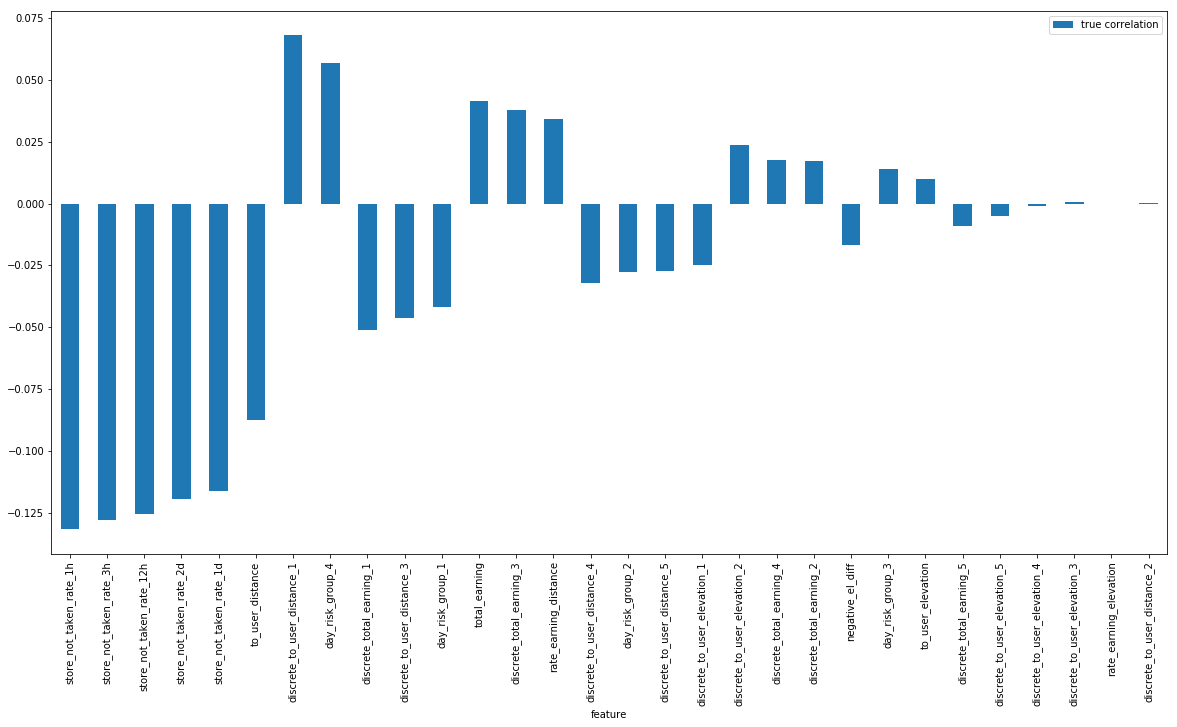

In [21]:
# Features correlation coefficent to label
fi = pd.DataFrame({'feature': list(discretized_dataset),
                   'correlation': discretized_dataset.corr()[LABEL].abs(),
                   'true correlation': discretized_dataset.corr()[LABEL]}).\
                    sort_values('correlation', ascending = False)

fi[fi.feature!=LABEL].plot.bar(x='feature', y ='true correlation', figsize=(20,10))

In [16]:

# Features correlation coefficent to label
fi = pd.DataFrame({'feature': list(discretized_dataset),
                   'correlation': discretized_dataset.corr()[LABEL].abs(),
                   'true correlation': discretized_dataset.corr()[LABEL]}).\
                    sort_values('correlation', ascending = False)

fi[fi.feature!=LABEL].plot.bar(x='feature', y ='true correlation', figsize=(20,10))

inf